### 방법1. 자연어처리 방법
- 한국어 처리 : OKT() 이용
- 토큰 임베딩 : Word2Vec

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip install konlpy koreanize_matplotlib gensim

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import koreanize_matplotlib
from konlpy.tag import Okt
from gensim.models import Word2Vec
from collections import Counter

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# 데이터 로드
df=pd.read_csv("./emergency_call_binary_tokens.csv", encoding="utf-8-sig")
df.head()


Unnamed: 0  id                    document label  \
0           0   1    골목길에서 싸움이 났어요 다친 사람이 있어요    긴급   
1           1   2      교통사고가 발생했는데 상대방이 도주했어요    긴급   
2           2   3      집 근처에서 폭죽 소리가 나고 시끄러워요    경미   
3           3   4  술집에서 손님끼리 다투고 있어요 경찰이 필요해요    긴급   
4           4   5         차에 누가 돌을 던졌어요 잡아주세요    경미   

                                    tokens  
0         ['골목길', '싸움', '나다', '다치다', '사람']  
1  ['교통사고', '발생', '하다', '상대방', '도주', '하다']  
2    ['집', '근처', '폭죽', '소리', '나다', '시끄럽다']  
3  ['술집', '손님', '끼리', '다투다', '경찰', '필요하다']  
4            ['차', '누가', '돌', '던지다', '잡다']

In [4]:
padding_len = 32       # 샘플의 최대 단어 길이 포함 패딩
embedding_dim = 1024

import ast
df['tokens'] = df['tokens'].apply(ast.literal_eval)

w2v_model = Word2Vec(sentences=df['tokens'], vector_size=embedding_dim, window=5, min_count=5, workers=4, sg=1)

In [5]:
from sklearn.preprocessing import LabelEncoder

def tokens_to_w2v_sequence(tokens_list, model, padding_len, embedding_dim):
    X_w2v_seq = []
    for tokens in tokens_list:
        vecs = []
        for word in tokens[:padding_len]:
            if word in model.wv:
                vecs.append(model.wv[word])
            else:
                vecs.append(np.zeros(embedding_dim))
        while len(vecs) < padding_len:
            vecs.append(np.zeros(embedding_dim))
        X_w2v_seq.append(vecs)
    return np.array(X_w2v_seq)

X = tokens_to_w2v_sequence(df['tokens'], w2v_model, padding_len, embedding_dim)
le = LabelEncoder()
y = le.fit_transform(df['label'])
print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (300, 32, 1024), y shape: (300,)


In [6]:
# 모든 토큰을 하나의 리스트로 펼침 (flatten)
all_tokens = [token for sublist in df['tokens'] for token in sublist]
unique_tokens = set(all_tokens)
# vocab_size = 고유 토큰 개수 + 1 (padding 등 고려 시)
vocab_size = len(unique_tokens) + 1

print(f"vocab_size: {vocab_size}")
print(f"max index in sequences: {np.max(X)}")

vocab_size: 427
max index in sequences: 0.0011779790511354804


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [8]:
model = Sequential([
    Flatten(),                          # (15, 100) → 1500차원 벡터
    Dense(128, activation='relu'),      # 첫 번째 은닉층
    Dropout(0.3),                       # 과적합 방지
    Dense(64, activation='relu'),       # 두 번째 은닉층 (선택)
    Dropout(0.3),
    Dense(1, activation='sigmoid')      # 출력층 (이진 분류)
])


In [9]:

from tensorflow.keras.optimizers import Adam
learning_rate = 0.01
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_split=0.1, callbacks=[early_stop], verbose=1)


Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.5879 - loss: 0.6852 - val_accuracy: 0.4444 - val_loss: 0.7406
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.5719 - loss: 0.6718 - val_accuracy: 0.4444 - val_loss: 0.7069
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6109 - loss: 0.6023 - val_accuracy: 0.5185 - val_loss: 0.6726
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.7562 - loss: 0.5088 - val_accuracy: 0.7778 - val_loss: 0.5712
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.8644 - loss: 0.3523 - val_accuracy: 0.7778 - val_loss: 0.4501
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9306 - loss: 0.2841 - val_accuracy: 0.7037 - val_loss: 0.5872
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.8956 - loss: 0.2518 - val_accuracy: 0.8519 - val_loss: 0.3648
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9266 - loss: 0.1691 - val_accuracy: 0.8148 - val_loss: 0.403

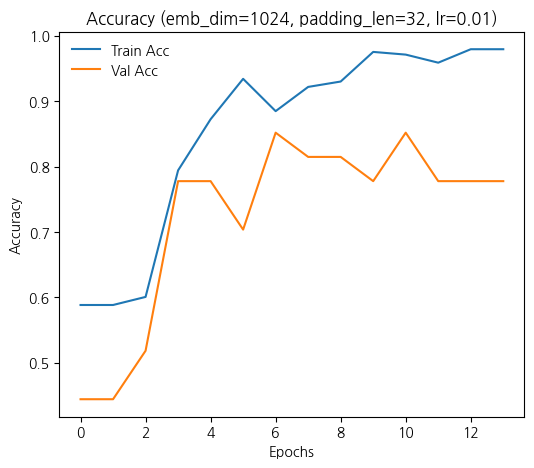

Test Accuracy: 0.6333, Loss: 0.9181


In [10]:
# Accuracy
plt.figure(figsize=(6, 5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title(f"Accuracy (emb_dim={embedding_dim}, padding_len={padding_len}, lr={learning_rate})")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(frameon=False)
plt.show()

# Loss
plt.figure(figsize=(6, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title(f"Loss (emb_dim={embedding_dim}, padding_len={padding_len}, lr={learning_rate})")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)
plt.show()

# 최종 평가
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}, Loss: {loss:.4f}")


## (과제) 하이퍼라미미터 최적화
1) embedding_length를 64, 128, 256, 512로 증가시켜 본다.
2) padding_len = 16, 24, 32로 증가 시켜본다.
3) learning_late 조절하다.

Test Accuracy가 가장 높은 하이퍼파라미터를 제출한다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
=== 분류 성능 보고서 ===
              precision    recall  f1-score   support

          경미       0.59      0.87      0.70        15
          긴급       0.75      0.40      0.52        15

    accuracy                           0.63        30
   macro avg       0.67      0.63      0.61        30
weighted avg       0.67      0.63      0.61        30



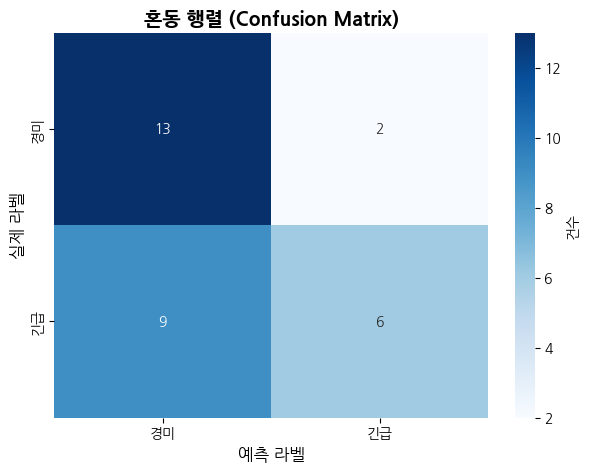

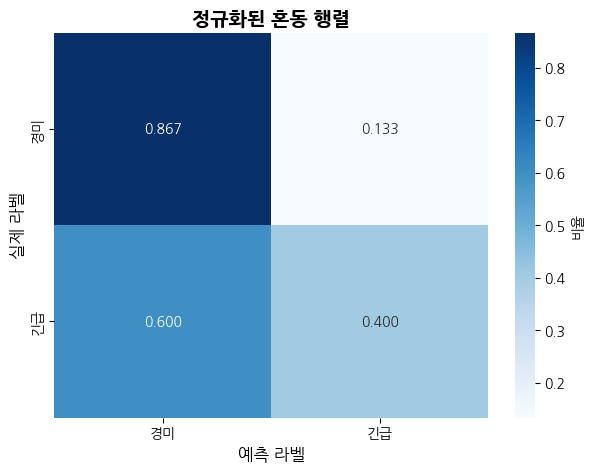

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

# Classification Report (한글)
# 예측 수행 (긴급=1, 경미=0 가정)
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("=== 분류 성능 보고서 ===")
print(classification_report(y_test, y_pred,
                          target_names=['경미', '긴급']))

# Confusion Matrix 계산 및 시각화
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['경미', '긴급'],
            yticklabels=['경미', '긴급'],
            cbar_kws={'label': '건수'})
plt.title('혼동 행렬 (Confusion Matrix)', fontsize=14, fontweight='bold')
plt.ylabel('실제 라벨', fontsize=12)
plt.xlabel('예측 라벨', fontsize=12)
plt.show()

# 정규화된 Confusion Matrix
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(7, 5))
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=['경미', '긴급'],
            yticklabels=['경미', '긴급'],
            cbar_kws={'label': '비율'})
plt.title('정규화된 혼동 행렬', fontsize=14, fontweight='bold')
plt.ylabel('실제 라벨', fontsize=12)
plt.xlabel('예측 라벨', fontsize=12)
plt.show()